In [51]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import warnings
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
KMEANS_CLUSTER1_TRAIN = [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 16, 17, 18, 19]
KMEANS_CLUSTER2_TRAIN = [2, 8, 9, 14, 15]

def load_unit_data(unit, folder):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    return pd.read_csv("../data/processed/{}/unit{}_rms_anomaly_excluded.csv".format(folder, unit_name), index_col=0)

def load_all_data(units='all'):
    if units == 'all':
        units = range(0, 20)
    df_all = pd.DataFrame()
    for idx, unit in enumerate(units):
        file_name = "../data/processed/train/unit{}_rms_more_features.csv".format("000{}".format(unit) if unit < 10 else "00{}".format(unit))
        file_df = pd.read_csv(file_name, index_col=0)
        file_df['timestamp'] = pd.to_datetime(file_df['timestamp'])
        df_all = df_all.append(file_df)
    return df_all
    

prepare feature: time remaining until failure

In [183]:
def prepare_features(folder='train'):
    unit_range = range(0, 20) if folder == 'train' else range(20, 50)
    for unit in unit_range:
        df_unit = load_unit_data(unit, folder)
        df_unit['timestamp'] = pd.to_datetime(df_unit['timestamp'])
        dt_max = df_unit['timestamp'].max()
        unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
        time_diffs, warnings_til_now, errors_til_now = [], [], []
        df_alarm = pd.read_csv("../data/raw/{}/unit{}_alarms.csv".format(folder, unit_name), header=None, names=['timestamp', 'warning'])
        df_alarm['timestamp'] = pd.to_datetime(df_alarm['timestamp'])
        for idx, row in df_unit.iterrows():
            # time diff in days until failure
            time_diff = dt_max - row['timestamp']
            time_diffs.append(divmod(time_diff.total_seconds(), 60)[0] / (60 * 24))

            # num of accumulated warnings/errors before current observation
            df_before = df_alarm[(df_alarm['timestamp'] < row['timestamp'])]
            accum_warnings = len(df_before[df_before['warning'] == 'warning'].index)
            accum_errors = len(df_before[df_before['warning'] == 'error'].index)
            warnings_til_now.append(accum_warnings)
            errors_til_now.append(accum_errors)

        df_unit['hours_to_failure'] = time_diffs
        df_unit['accumulated_warnings'] = warnings_til_now
        df_unit['accumulated_errors'] = errors_til_now
        df_unit.to_csv("../data/processed/{}/unit{}_rms_more_features.csv".format(folder, unit_name))
    print("Done")

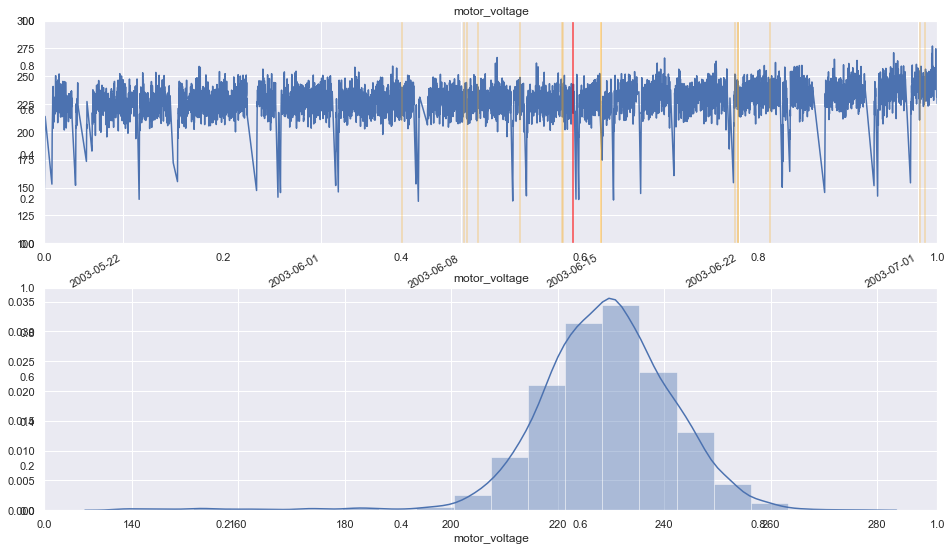

In [42]:
def plot_feature_in_df(unit, feature_name, ylim_low=-20, ylim_high=3000, bins=20):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    df_unit = pd.read_csv("../data/processed/train/unit{}_rms_anomaly_excluded.csv".format(unit_name), index_col=0)
    df_unit['timestamp'] = pd.to_datetime(df_unit['timestamp'])
    sns.set()
    fig, axs = plt.subplots(2, 1, figsize=(16, 10))
    ax1 = fig.add_subplot(211)
    ax1.title.set_text(feature_name)
    df_unit.set_index('timestamp', inplace=True)
    if ylim_low is None and ylim_high is None:
        df_unit[feature_name].plot(label=feature_name)
    else:
        df_unit[feature_name].plot(ylim=(ylim_low, ylim_high), label=feature_name)
        
    # plot warnings and errors
    df_alarm = pd.read_csv("../data/raw/train/unit{}_alarms.csv".format(unit_name), header=None, names=['timestamp', 'warning'])
    df_alarm['timestamp'] = pd.to_datetime(df_alarm['timestamp'])
    df_alarm.set_index('timestamp', inplace=True)
    warning_x = df_alarm[df_alarm['warning'] == 'warning'].index.values
    error_x = df_alarm[df_alarm['warning'] == 'error'].index.values
    for warning in warning_x:
        plt.axvline(x=warning, color='orange', alpha=0.3, label='warning')
    for error in error_x:
        plt.axvline(x=error, color='red', alpha=0.7, label='error')
    #plt.legend()
    ax2 = fig.add_subplot(212)
    sns.distplot(df_unit[feature_name], bins=bins)
    ax2.title.set_text(feature_name)
    plt.show()
plot_feature_in_df(15, 'motor_voltage', ylim_low=100, ylim_high=300)

In [22]:
df_all = load_all_data()
df_all

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,days_to_failure,accumulated_warnings,accumulated_errors
53,2003-12-14 04:45:12.721247385,956.579922,217.484012,25.042943,63.002208,34.350839,636.535417,0,0
54,2003-12-14 04:55:40.840586778,1063.856934,206.792646,28.782024,69.830473,28.464714,636.528472,0,0
55,2003-12-14 05:05:37.291038943,1005.212018,219.900341,29.302032,68.019838,39.165607,636.521528,0,0
56,2003-12-14 05:17:06.465193131,1115.011284,220.373208,30.767473,79.283341,32.983723,636.513194,0,0
57,2003-12-14 05:25:31.807130176,1028.243351,194.055713,28.676094,75.055177,37.553089,636.507639,0,0
...,...,...,...,...,...,...,...,...,...
24341,2005-04-11 18:16:25.989419843,1042.179737,307.539123,47.975455,218.791347,100.807647,0.027778,53,1
24342,2005-04-11 18:26:55.689073846,1069.597134,297.454082,47.263750,218.882763,109.359761,0.020139,53,1
24343,2005-04-11 18:35:25.402556965,1116.392388,316.277175,50.395914,218.935540,102.472228,0.014583,53,1
24344,2005-04-11 18:45:44.900113142,1122.974015,320.776152,49.165122,225.527057,103.086940,0.006944,53,1


In [41]:
def get_train_test_sets(df_input, test_size=0.2):
    df_input_features = df_input[df_input.columns[1:]]
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])
    
    Y_LABEL = 'days_to_failure'
    train_set, test_set = train_test_split(df_input_features, test_size=test_size, random_state=42)
    x_train = num_pipeline.fit_transform(train_set.drop(columns=[Y_LABEL], axis=1))
    x_test = num_pipeline.fit_transform(test_set.drop(columns=[Y_LABEL], axis=1))
    y_train, y_test = num_pipeline.fit_transform(train_set[[Y_LABEL]]), num_pipeline.fit_transform(test_set[[Y_LABEL]])
    return x_train, x_test, y_train, y_test
    
x_train, x_test, y_train, y_test = get_train_test_sets(df_all)

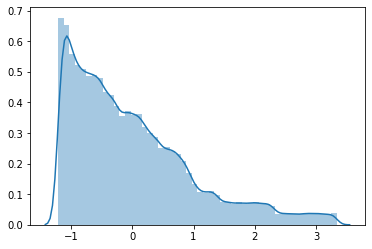

In [46]:
sns.distplot(pd.DataFrame(y_train))

In [6]:
def save_keras_model(model, history, file_name):
    model_json = model.to_json()
    with open("../models/failure_predicting/{}.json".format(file_name), 'w') as json_file:
        json_file.write(model_json)
    model.save_weights("../models/failure_predicting/{}.h5".format(file_name))
    with open('../models/failure_predicting/{}.history'.format(file_name), 'wb') as file_history:
        pickle.dump(history.history, file_history)
    print("model saved")
    
def load_nn_model(model_name):
    with open('../models/failure_predicting/{}.json'.format(model_name)) as f:
        nn_model = model_from_json(f.read())
    nn_model.load_weights('../models/failure_predicting/{}.h5'.format(model_name))
    return nn_model

Keras model constructed
Train on 668903 samples, validate on 167226 samples
Epoch 1/100
668903/668903 [==============================] - 71s 106us/step - loss: 0.5223 - coeff_determination: 0.4524 - val_loss: 0.4813 - val_coeff_determination: 0.5015
Epoch 2/100
668903/668903 [==============================] - 67s 101us/step - loss: 0.4499 - coeff_determination: 0.5300 - val_loss: 0.4283 - val_coeff_determination: 0.5552
Epoch 3/100
668903/668903 [==============================] - 68s 101us/step - loss: 0.4382 - coeff_determination: 0.5424 - val_loss: 0.4356 - val_coeff_determination: 0.5460
Epoch 4/100
668903/668903 [==============================] - 68s 101us/step - loss: 0.4312 - coeff_determination: 0.5497 - val_loss: 0.4293 - val_coeff_determination: 0.5509
Epoch 5/100
668903/668903 [==============================] - 68s 101us/step - loss: 0.4262 - coeff_determination: 0.5548 - val_loss: 0.4406 - val_coeff_determination: 0.5419
Epoch 6/100
668903/668903 [===========================

668903/668903 [==============================] - 66s 99us/step - loss: 0.3941 - coeff_determination: 0.5858 - val_loss: 0.3812 - val_coeff_determination: 0.5961
Epoch 48/100
668903/668903 [==============================] - 66s 99us/step - loss: 0.3939 - coeff_determination: 0.5859 - val_loss: 0.3775 - val_coeff_determination: 0.6040
Epoch 49/100
668903/668903 [==============================] - 67s 99us/step - loss: 0.3935 - coeff_determination: 0.5870 - val_loss: 0.4084 - val_coeff_determination: 0.5658
Epoch 50/100
668903/668903 [==============================] - 67s 100us/step - loss: 0.3944 - coeff_determination: 0.5870 - val_loss: 0.4084 - val_coeff_determination: 0.5748
Epoch 51/100
668903/668903 [==============================] - 67s 100us/step - loss: 0.3922 - coeff_determination: 0.5888 - val_loss: 0.3801 - val_coeff_determination: 0.6041
Epoch 52/100
668903/668903 [==============================] - 67s 99us/step - loss: 0.3928 - coeff_determination: 0.5877 - val_loss: 0.3862 -

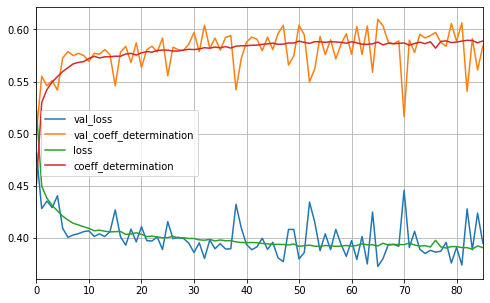

In [64]:
def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

def create_keras_model(optimizer='adam', neuron=50, init='lecun_normal', act_alpha=0.01):
    model_sequences = [
        keras.layers.Dense(units=neuron, kernel_initializer=init, input_shape=x_train.shape[1:]),
        keras.layers.LeakyReLU(alpha=act_alpha)
    ]
    
    for i in range(5):
        model_sequences.append(keras.layers.Dense(units=neuron, kernel_initializer=init,
                                                  input_shape=x_train.shape[1:]))
        model_sequences.append(keras.layers.LeakyReLU(alpha=act_alpha))
        
    #model_sequences.append(keras.layers.BatchNormalization())
    model_sequences.append(Dense(units=1, name='score_output'))
    model_sequences.append(keras.layers.LeakyReLU(alpha=act_alpha))
    #model_sequences.append(keras.layers.Activation(activation))

    nn_model = keras.models.Sequential(model_sequences)
    nn_model.compile(optimizer=optimizer, loss='mse', metrics=[coeff_determination])
    return nn_model

nn_model = create_keras_model(optimizer='Adadelta', neuron=100, init='lecun_uniform', act_alpha=0.05)
print("Keras model constructed")
early_stopping_cb = EarlyStopping(patience=20)
history = nn_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, callbacks=[early_stopping_cb], verbose=1)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [65]:
save_keras_model(nn_model, history, "overall_100_epoch_es")

model saved


In [20]:
prepare_features(folder='test')

Done


In [190]:
def get_time_delta_seconds(time_delta):
    return time_delta.seconds + time_delta.days * 86400

def predict_unit(model, unit, delta_days=15):
    Y_LABEL = 'days_to_failure'
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    df_pred_unit_original = pd.read_csv("../data/processed/test/unit{}_rms_more_features.csv".format(unit_name), index_col=0)
    #df_pred_unit = df_pred_unit_original.drop(columns=[Y_LABEL])
    nd_pred_unit = num_pipeline.fit_transform(df_pred_unit_original[df_pred_unit_original.columns[1:]])
    predictions_scaled = model.predict(nd_pred_unit)
    
    y_scaler = StandardScaler().fit(train_set[[Y_LABEL]])
    predictions = y_scaler.inverse_transform(predictions_scaled)
    #plt.plot(predictions)
    
    every_fail_time = []
    df_pred_unit_original['timestamp'] = pd.to_datetime(df_pred_unit_original['timestamp'])
    date_max = max(df_pred_unit_original['timestamp'])
    predicted_failures = 0
    for num_idx, pred in enumerate(predictions):
        pred = float(predictions[num_idx][0])
        failure_time = df_pred_unit_original.iloc[num_idx]['timestamp'] + timedelta(days=pred)
        # predicted to fail within delta_days
        if failure_time <= (date_max + timedelta(days=delta_days)):
            predicted_failures += 1
        every_fail_time.append(failure_time)
    
    date_min, date_max = min(every_fail_time), max(every_fail_time)
    #print('date_min:{}, date_max:{}'.format(date_min, date_max))
    time_deltas = [get_time_delta_seconds(spot - date_min) for spot in every_fail_time]
    avg_time_delta = sum(time_deltas) / len(time_deltas)
    #print("avg_time_delta:{}".format(avg_time_delta))
    final_avg_result = date_min + timedelta(seconds=avg_time_delta)
    #print("unit {} final avg result:{}".format(unit, final_avg_result))
    print("unit {} failure prob:{}, avg:{}".format(unit, float(predicted_failures) / len(predictions), final_avg_result))
    return final_avg_result

In [191]:
nn_model = load_nn_model('sequential_10_epoch')
avg_results = [predict_unit(nn_model, unit, delta_days=15) for unit in range(20, 50)]

unit 20 failure prob:0.004495504495504496, avg:2020-01-04 22:05:14.540094589
unit 21 failure prob:0.019194376858610435, avg:2019-11-29 22:48:16.898128325
unit 22 failure prob:0.003185635679119606, avg:2019-09-17 01:00:11.601295005
unit 23 failure prob:0.03563941299790356, avg:2019-05-01 14:38:01.118683170
unit 24 failure prob:0.015861027190332326, avg:2020-01-07 16:04:36.317859601
unit 25 failure prob:0.07538802660753881, avg:2019-05-14 02:48:12.615756997
unit 26 failure prob:0.03182885468301591, avg:2019-11-02 12:58:41.155727686
unit 27 failure prob:0.07652439024390244, avg:2019-07-12 02:23:53.314692474
unit 28 failure prob:0.008285004142502071, avg:2020-02-11 04:39:53.103280127
unit 29 failure prob:0.007378129117259552, avg:2020-03-19 04:43:08.925879291
unit 30 failure prob:0.0, avg:2019-08-09 10:07:02.843273174
unit 31 failure prob:0.0010465724751439038, avg:2020-04-20 03:44:34.981823880
unit 32 failure prob:0.1725, avg:2019-04-05 07:03:39.273278705
unit 33 failure prob:0.0082452976

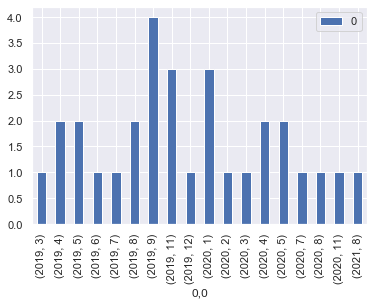

In [192]:
avg_dates = [datetime(r.year, r.month, 15) for r in avg_results]
df_avg_dates = pd.DataFrame(avg_dates)
df_avg_dates.groupby([df_avg_dates[0].dt.year, df_avg_dates[0].dt.month]).count().plot(kind="bar")